# Optimizer with Momentum and Sign of Gradient: A Benchmark Test

In this notebook, we implement and test the optimizer with "Momentum and Sign of Gradient" ("masog" for short). It is compared with the state-of-the-art optimizer [Adam](https://arxiv.org/abs/1412.6980).

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# For reproducibility
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

Here, we implement the optimizer by TensorFlow. In this implementation , there are plenty of things to be optimized but we keep it simple.

In [19]:
class Masog:
    """A simple implementation of optimizer with "Momentum and Sign of Gradient"."""

    def __init__(self, learning_rate=2e-4, decay_factor=0.95):
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor

    def build(self, variable_shapes):
        self.momenta = []
        for shape in variable_shapes:
            v = tf.Variable(tf.zeros(shape))
            self.momenta.append(v)
        return self

    def apply_gradients(self, grads_and_vars):
        for i, (grad, var) in enumerate(grads_and_vars):
            self.momenta[i] = self.decay_factor * self.momenta[i] + (1-self.decay_factor) * grad
            var.assign_sub(self.learning_rate * tf.math.sign(self.momenta[i]))


def get_variable_shapes(model):
    return [var.shape for var in model.variables]

Then, we download and preprocess the dataset. We use MNIST (or fashion-MNIST) for the benchmark test.

In [32]:
# Preprocess MNIST
# mnist = tf.keras.datasets.mnist
mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), _ = mnist.load_data()
x_train = x_train.astype('float32')
x_train = x_train.reshape([-1, 28, 28, 1])  # add channel.
x_train = x_train / 255.0
y_train = y_train.astype('int32')

# Convert to dataset
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_train = ds_train.batch(64)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Two models are employed in our benchmark test. We first consider a simple feed-forward network with ReLU activation. And then a simple convolutional network.

In [16]:
# Feed-forward netowrk
init_ffd = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(64, 'relu'),
    tf.keras.layers.Dense(10),
])

# Convolutional network
init_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, 3),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(10),
])

# Build the models
x_batch = tf.random.uniform([128, 28, 28, 1])
init_ffd(x_batch)
init_cnn(x_batch)


def get_num_params(model):
    num_params = 0
    for v in model.variables:
        num_params += tf.reduce_prod(tf.shape(v)).numpy()
    return num_params


get_num_params(init_ffd), get_num_params(init_cnn)

(109386, 1199882)

Then functions for training the models.

In [27]:
def cross_entropy_loss(logits, labels):
    """Compute cross entropy loss with a sparse operation."""
    loss_per_sample = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels)
    return tf.reduce_mean(loss_per_sample)


def train_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        loss_batch = cross_entropy_loss(y_pred, y_batch)
    grads = tape.gradient(loss_batch, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss_batch


def train(model, optimizer, dataset, epochs):
    loss_values = []
    for epoch in range(epochs):
        ds_iter = dataset.as_numpy_iterator()
        while True:
            try:
                x_batch, y_batch = next(ds_iter)
            except StopIteration:
                break
            loss_batch = train_step(model, optimizer, x_batch, y_batch)
            loss_values.append(loss_batch.numpy())
            if np.isnan(loss_values[-1]):
                raise ValueError('NaN')
    return loss_values

Each model is first cloned before training. In this way, the comparison is made on the same model, with the same initial values of variable.

In [ ]:
def clone_model(model):
    new_model = tf.keras.models.clone_model(model)
    for i, var in enumerate(model.variables):
        new_model.variables[i].assign(var)
    return new_model

And for better visualization, we use moving average to make the training loss smooth.

In [ ]:
def moving_average(values, decay_factor=0.95):
    avgs = []
    for value in values:
        if not avgs:
            avgs.append(value)
        else:
            avgs.append(decay_factor*avgs[-1] + (1-decay_factor)*value)
    return avgs

With all the preparations, we start benchmark test, on feed-forward network.

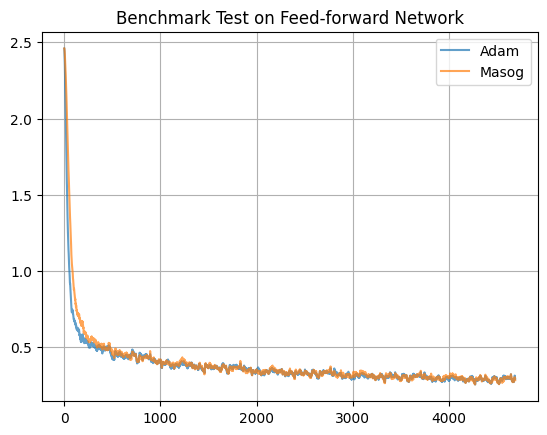

In [34]:
adam_loss_values = train(
    clone_model(init_ffd),
    tf.keras.optimizers.Adam(),
    ds_train,
    epochs=5)
plt.plot(moving_average(adam_loss_values), label='Adam', alpha=0.7)

masog_loss_values = train(
    clone_model(init_ffd),
    Masog().build(get_variable_shapes(init_ffd)),
    ds_train,
    epochs=5)
plt.plot(moving_average(masog_loss_values), label='Masog', alpha=0.7)

plt.legend()
plt.grid()
plt.title('Benchmark Test on Feed-forward Network')
plt.show()

Then on convolutional network.

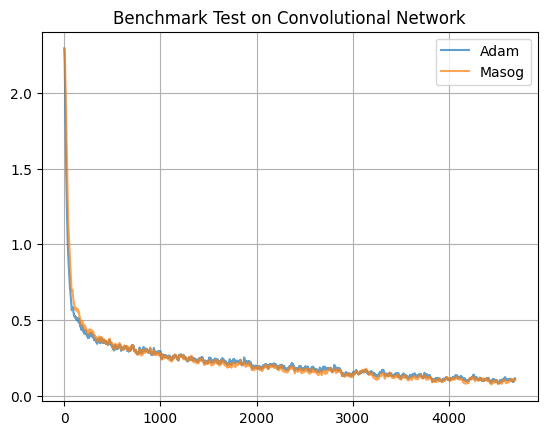

In [35]:
adam_loss_values = train(
    clone_model(init_cnn),
    tf.keras.optimizers.Adam(),
    ds_train,
    epochs=5)
plt.plot(moving_average(adam_loss_values), label='Adam', alpha=0.7)

masog_loss_values = train(
    clone_model(init_cnn),
    Masog().build(get_variable_shapes(init_cnn)),
    ds_train,
    epochs=5)
plt.plot(moving_average(masog_loss_values), label='Masog', alpha=0.7)

plt.legend()
plt.grid()
plt.title('Benchmark Test on Convolutional Network')
plt.show()

For both feed-forward network and convolutional network, the training loss of Adam is almost the same as that of Masog. So, Masog performs as good as Adam.

In the end, we explore the effect of decay factor. To do so, we plot the training loss for different value of decay factor.

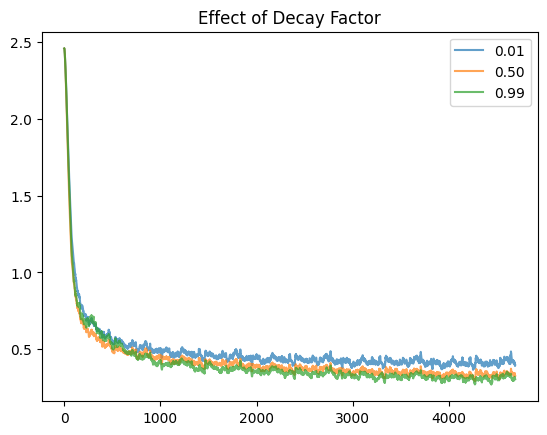

In [36]:
decay_factors = (0.01, 0.5, 0.99)
for decay_factor in decay_factors:
    loss_values = train(
        clone_model(init_ffd),
        Masog(decay_factor=decay_factor).build(get_variable_shapes(init_ffd)),
        ds_train,
        epochs=5)
    plt.plot(moving_average(loss_values),
             label=f'{decay_factor:.2f}', alpha=0.7)
plt.legend()
plt.title('Effect of Decay Factor')
plt.show()

We find that the greater value of decay factor furnishes a better performance. This is consistent with our analysis that decay factor can reduce the stochastic disturbance and, thus, speed up the optimization.